TOTAL SIMS IS: 1
CURRENT HOUR IS 10, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.171875 s. Total wall time: 8.574280261993408 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.553 
Out Of Rail Stability Margin - Standard Deviation: 0.049 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 86.0%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5273714540191878, 1.5782155226029284



Apogee Altitude -         Mean Value: 2985.557 
Apogee Altitude - Standard Deviation: 0.397 m


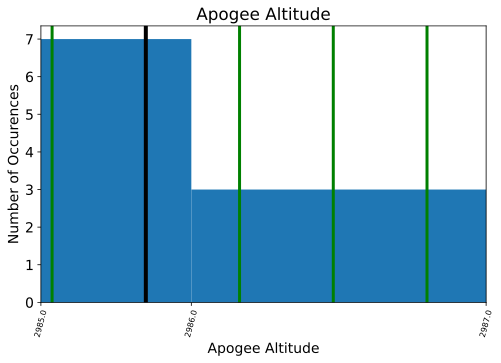

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2985.3504151542115, 2985.763838457155

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -496.87274867944745
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


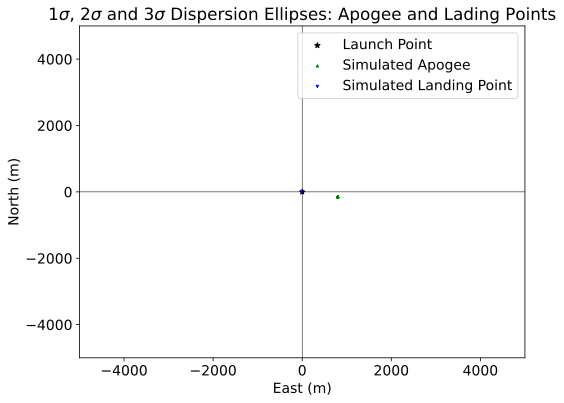




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 11, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.109375 s. Total wall time: 8.309434175491333 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.547 
Out Of Rail Stability Margin - Standard Deviation: 0.040 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 88.01%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5262972383270534, 1.568054920728789



Apogee Altitude -         Mean Value: 2977.189 
Apogee Altitude - Standard Deviation: 0.425 m


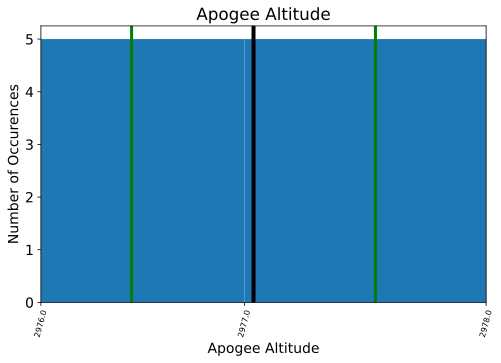

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2976.968104154597, 2977.410290081278

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -526.807385399973
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


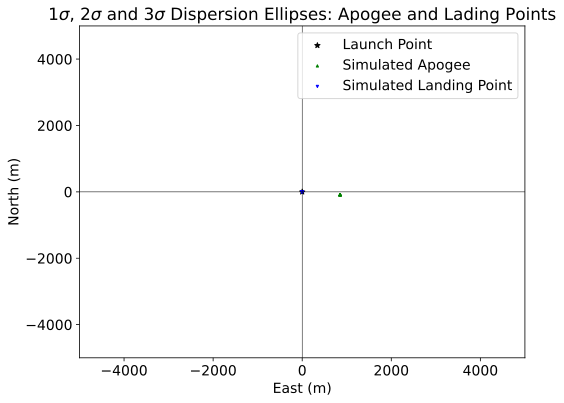




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 12, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.109375 s. Total wall time: 10.244367122650146 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.543 
Out Of Rail Stability Margin - Standard Deviation: 0.035 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 88.58%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5242098389824037, 1.5610090524065774



Apogee Altitude -         Mean Value: 2965.531 
Apogee Altitude - Standard Deviation: 0.336 m


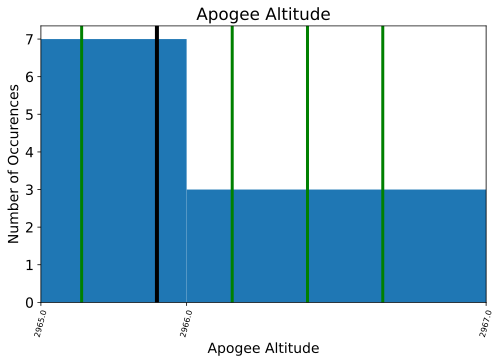

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2965.3567772572, 2965.706142600489

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -776.5434085044421
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


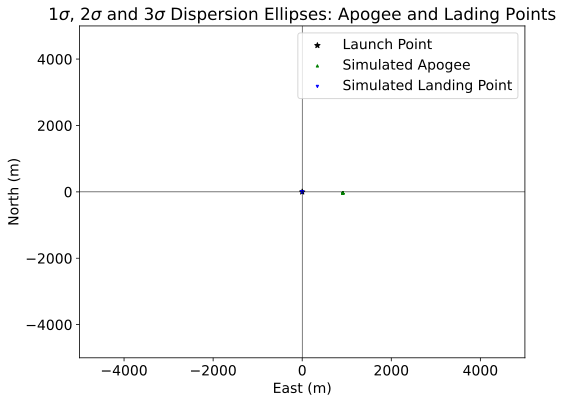




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 13, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.125 s. Total wall time: 10.474186420440674 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.564 
Out Of Rail Stability Margin - Standard Deviation: 0.058 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 86.64%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.533981528588213, 1.593977133677957



Apogee Altitude -         Mean Value: 2957.323 
Apogee Altitude - Standard Deviation: 0.602 m


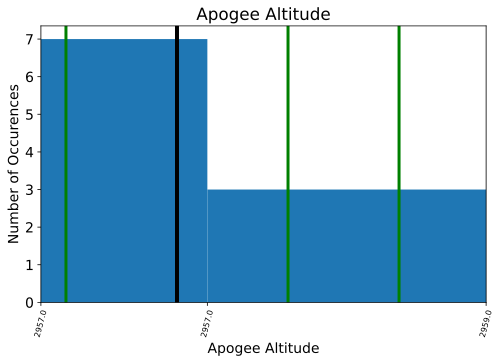

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2957.010131550351, 2957.6365882544173

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -476.1695401335473
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 2276.764349220675, y = -130.107986188123


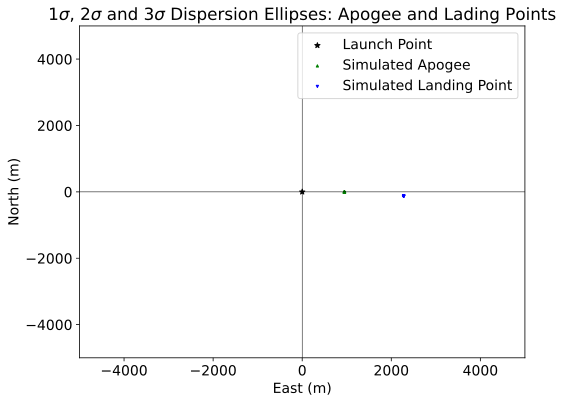




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 14, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.15625 s. Total wall time: 9.943918466567993 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.557 
Out Of Rail Stability Margin - Standard Deviation: 0.053 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 85.74%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5292265278054886, 1.5846712088900183



Apogee Altitude -         Mean Value: 2957.431 
Apogee Altitude - Standard Deviation: 0.452 m


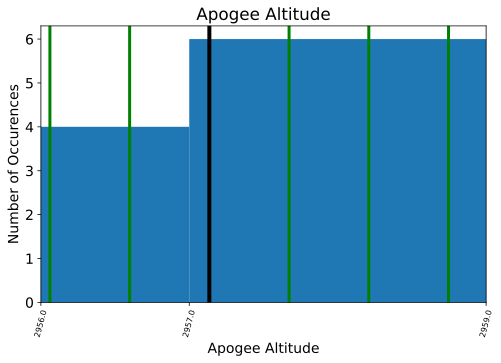

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2957.1961324784843, 2957.6662341911415

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -633.7881465629913
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 2223.3849668498933, y = -122.33116187270757


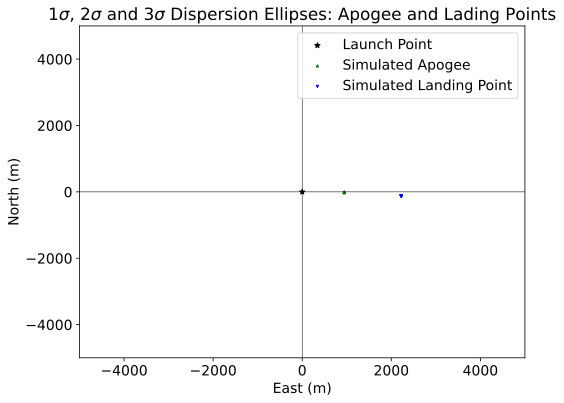




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 15, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.09375 s. Total wall time: 9.818499565124512 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.537 
Out Of Rail Stability Margin - Standard Deviation: 0.031 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 88.73%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5212659238521327, 1.5532406906582552



Apogee Altitude -         Mean Value: 2961.082 
Apogee Altitude - Standard Deviation: 0.317 m


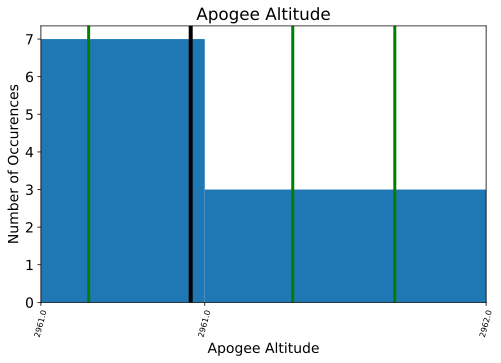

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2960.9165243596685, 2961.246566448383

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -866.3630499254424
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


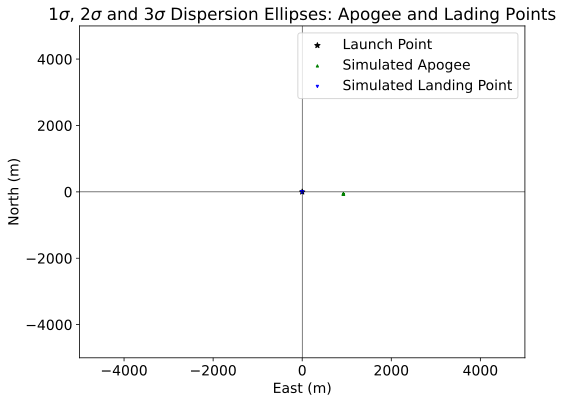




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 16, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.203125 s. Total wall time: 10.108253717422485 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.560 
Out Of Rail Stability Margin - Standard Deviation: 0.049 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 89.0%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5346863189221043, 1.5857860235512315



Apogee Altitude -         Mean Value: 2964.895 
Apogee Altitude - Standard Deviation: 0.502 m


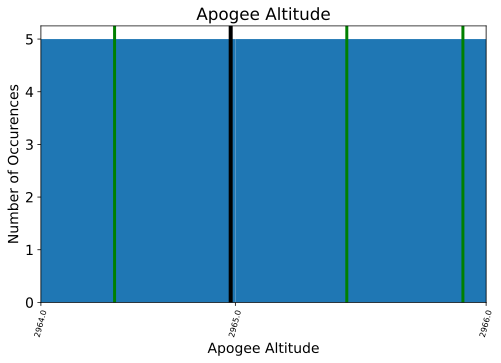

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2964.633653462825, 2965.1562152503243

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -523.1751418169932
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


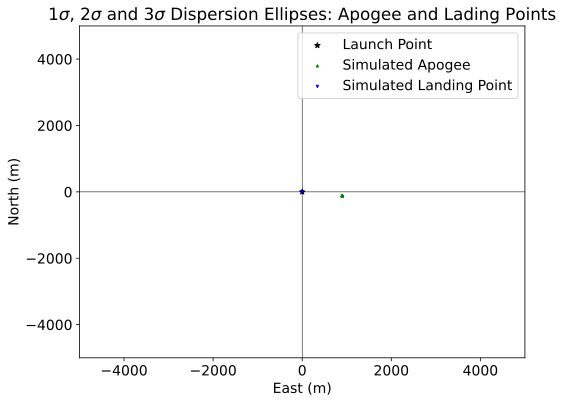




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 17, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.15625 s. Total wall time: 10.110349178314209 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.554 
Out Of Rail Stability Margin - Standard Deviation: 0.050 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 86.0%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.528139583458626, 1.5803957635636585



Apogee Altitude -         Mean Value: 2968.055 
Apogee Altitude - Standard Deviation: 0.500 m


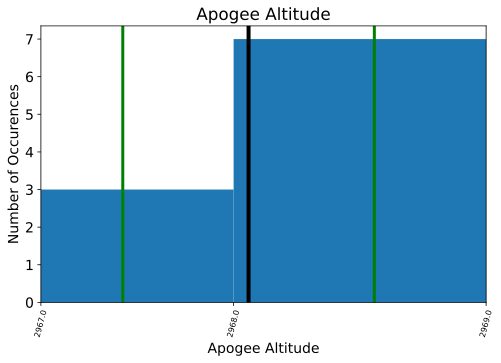

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2967.7953093973656, 2968.3155787005617

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -505.49625743205115
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


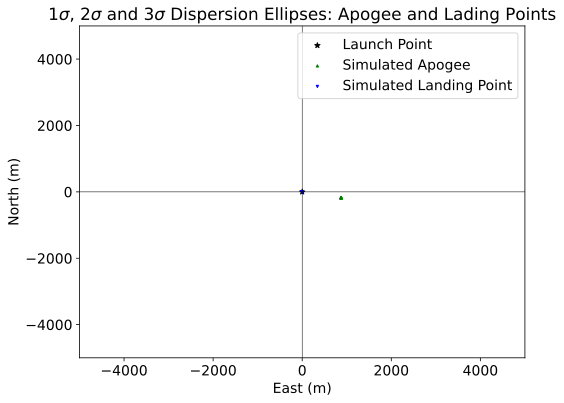




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 18, CURRENT DAY IS: 11


'Completed 1 iterations successfully. Total CPU time: 0.109375 s. Total wall time: 9.573464393615723 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.569 
Out Of Rail Stability Margin - Standard Deviation: 0.052 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 90.63%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5417587700096516, 1.5962035553905862



Apogee Altitude -         Mean Value: 2970.936 
Apogee Altitude - Standard Deviation: 0.505 m


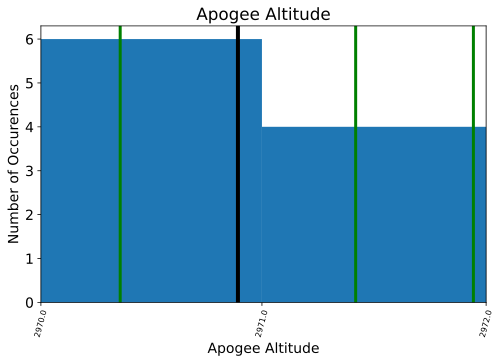

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2970.6738752942333, 2971.198775757733

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -482.9809584070189
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


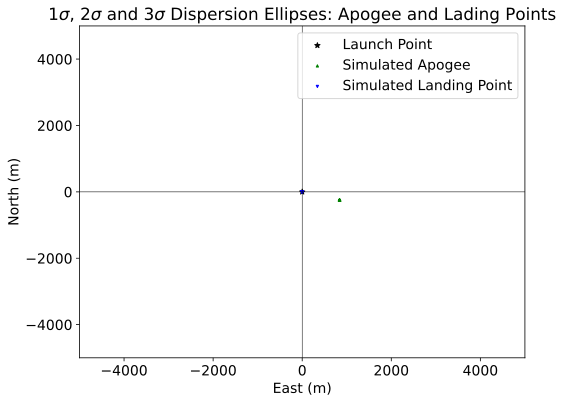




----------------------------------------------------------------------------------------------------





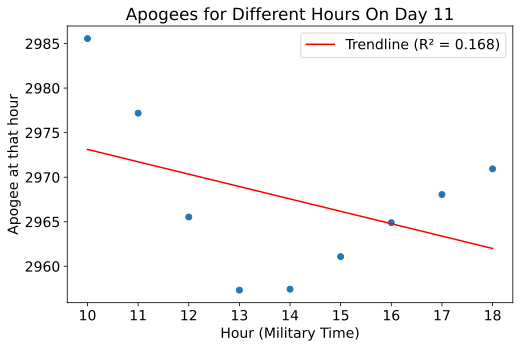

CURRENT HOUR IS 10, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.125 s. Total wall time: 9.822041034698486 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.552 
Out Of Rail Stability Margin - Standard Deviation: 0.039 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 90.86%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5314262408369568, 1.5717007366874203



Apogee Altitude -         Mean Value: 3024.870 
Apogee Altitude - Standard Deviation: 0.239 m


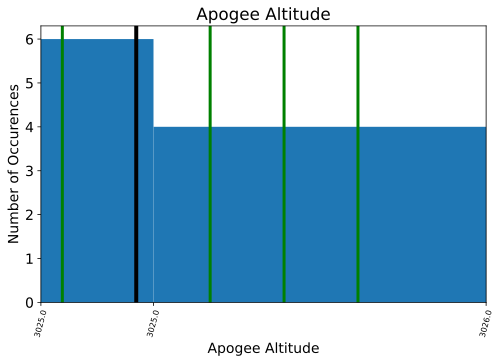

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3024.7456346550807, 3024.9939897030554

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -306.38212220491704
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


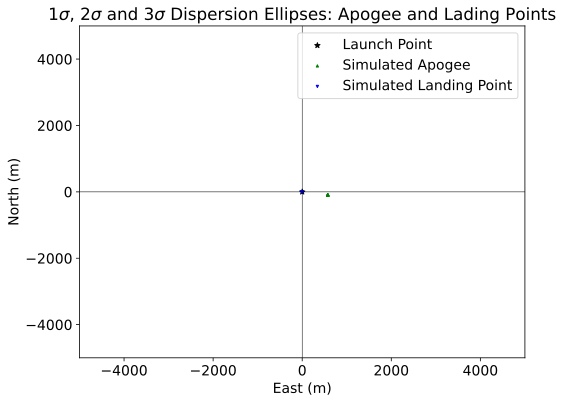




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 11, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.078125 s. Total wall time: 9.52248477935791 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.575 
Out Of Rail Stability Margin - Standard Deviation: 0.028 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 99.58%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5600069382690824, 1.5894871536435704



Apogee Altitude -         Mean Value: 3014.823 
Apogee Altitude - Standard Deviation: 0.165 m


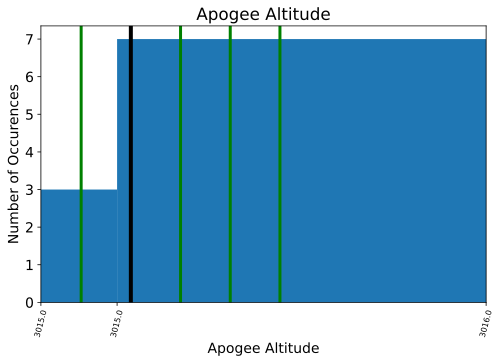

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3014.7373115390265, 3014.9086020449868

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -637.1792709266977
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


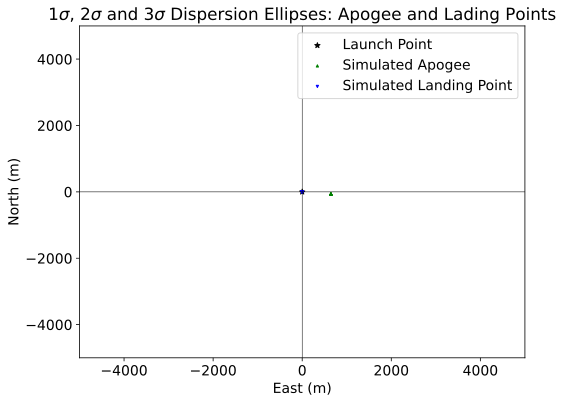




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 12, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.09375 s. Total wall time: 9.675410747528076 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.549 
Out Of Rail Stability Margin - Standard Deviation: 0.047 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 85.38%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5249298616123113, 1.5736079263717648



Apogee Altitude -         Mean Value: 3003.214 
Apogee Altitude - Standard Deviation: 0.191 m


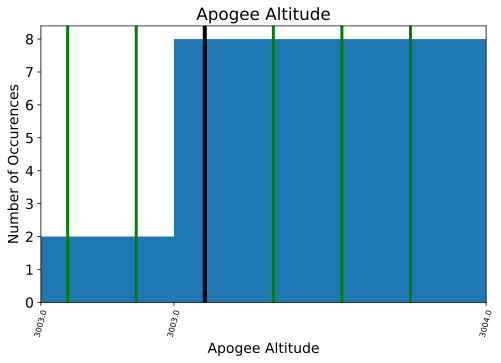

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3003.114606554066, 3003.3138041214506

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -739.6282771245842
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


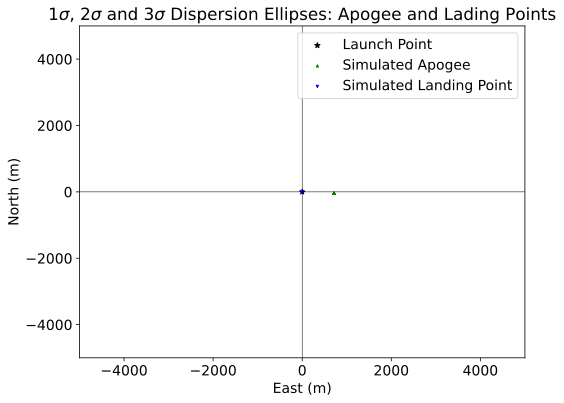




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 13, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.171875 s. Total wall time: 10.079355716705322 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.545 
Out Of Rail Stability Margin - Standard Deviation: 0.041 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 86.55%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.523914929575932, 1.5664265452087986



Apogee Altitude -         Mean Value: 2993.962 
Apogee Altitude - Standard Deviation: 0.413 m


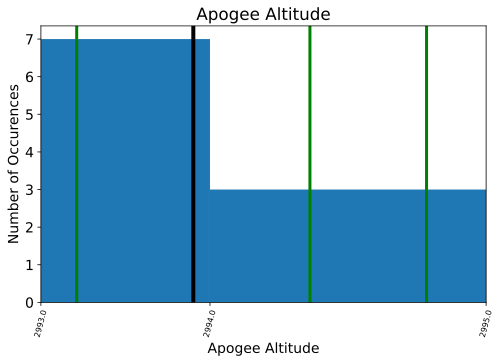

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2993.7473197254335, 2994.177241915328

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -413.48941959272634
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


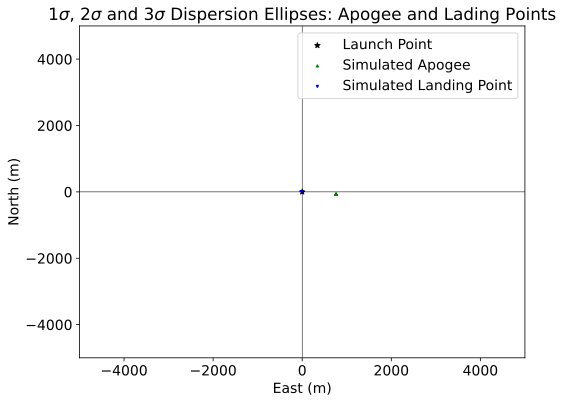




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 14, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.171875 s. Total wall time: 10.211191892623901 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.559 
Out Of Rail Stability Margin - Standard Deviation: 0.048 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 88.74%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.533525556537497, 1.5838796451154558



Apogee Altitude -         Mean Value: 2987.360 
Apogee Altitude - Standard Deviation: 0.354 m


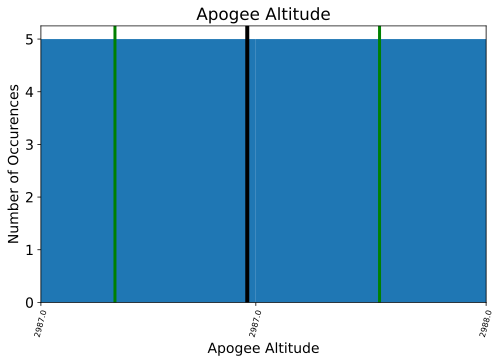

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2987.1755529406682, 2987.5443115025982

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -540.9720381916213
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


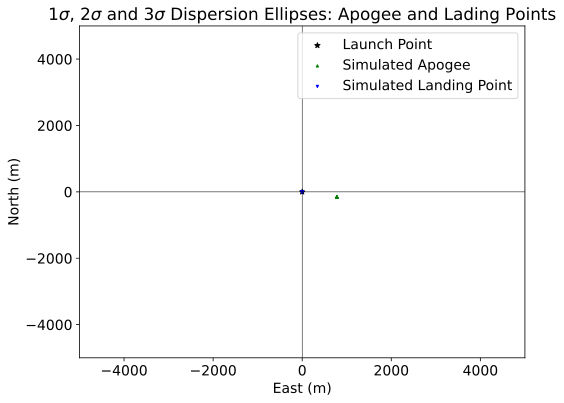




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 15, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.0625 s. Total wall time: 9.813188314437866 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.569 
Out Of Rail Stability Margin - Standard Deviation: 0.051 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 91.34%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5429245757549512, 1.5959716555205261



Apogee Altitude -         Mean Value: 2980.909 
Apogee Altitude - Standard Deviation: 0.394 m


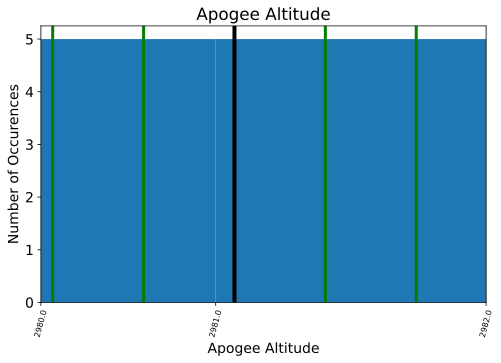

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2980.7034992026547, 2981.113551990871

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -538.250967587342
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


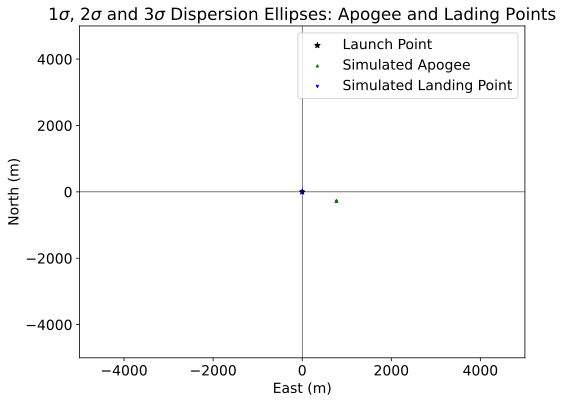




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 16, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.203125 s. Total wall time: 9.805494546890259 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.551 
Out Of Rail Stability Margin - Standard Deviation: 0.045 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 87.31%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5276652054678943, 1.57400550153178



Apogee Altitude -         Mean Value: 2969.653 
Apogee Altitude - Standard Deviation: 0.331 m


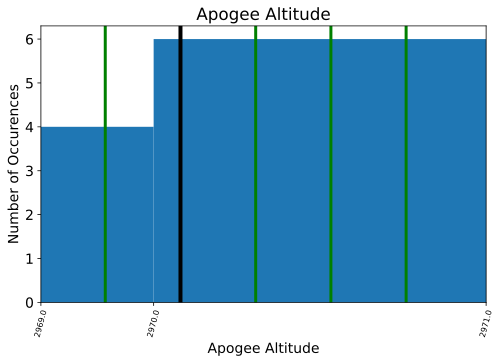

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2969.4808932089, 2969.8256472266003

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -747.5991346044032
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


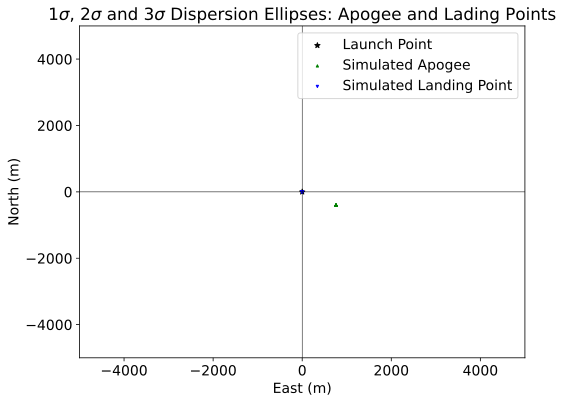




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 17, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.078125 s. Total wall time: 9.579807043075562 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.580 
Out Of Rail Stability Margin - Standard Deviation: 0.051 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 94.16%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5536399377764785, 1.6068542273122615



Apogee Altitude -         Mean Value: 2954.712 
Apogee Altitude - Standard Deviation: 0.603 m


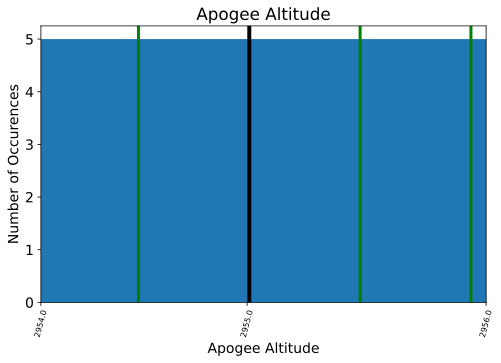

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2954.3987768531947, 2955.0256675125224

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -489.54227474827155
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 2691.2173117975626, y = 2184.4582748404728


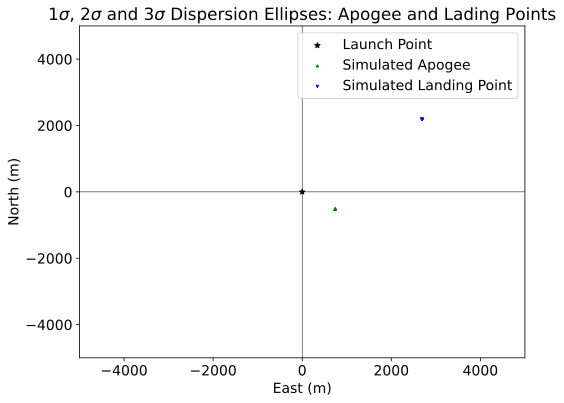




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 18, CURRENT DAY IS: 12


'Completed 1 iterations successfully. Total CPU time: 0.171875 s. Total wall time: 9.590118408203125 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.549 
Out Of Rail Stability Margin - Standard Deviation: 0.044 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 86.66%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5261276748344226, 1.5721567596858994



Apogee Altitude -         Mean Value: 2936.408 
Apogee Altitude - Standard Deviation: 0.796 m


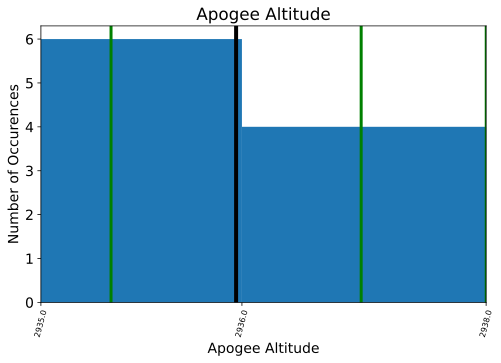

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2935.9938558126023, 2936.8222726892536

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -443.1401759881502
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 2853.0724905410757, y = 2380.7384281150626


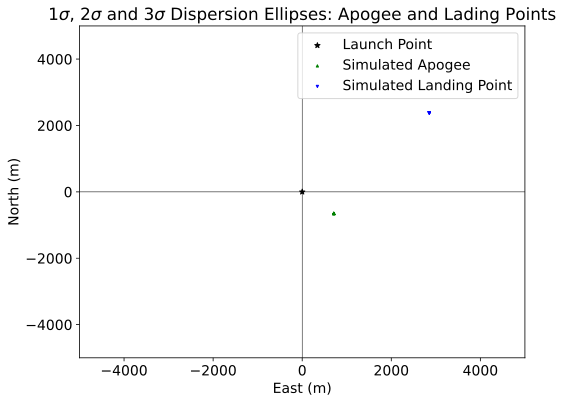




----------------------------------------------------------------------------------------------------





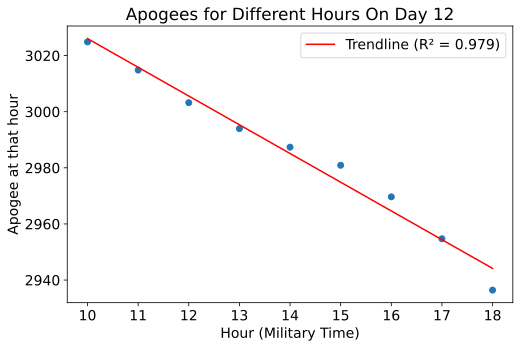

CURRENT HOUR IS 10, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.09375 s. Total wall time: 9.759214162826538 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.541 
Out Of Rail Stability Margin - Standard Deviation: 0.050 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 79.78%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.515569113639826, 1.5671991025181329



Apogee Altitude -         Mean Value: 3046.306 
Apogee Altitude - Standard Deviation: 0.170 m


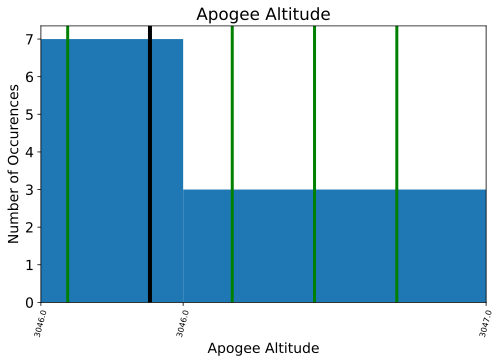

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3046.2181438185935, 3046.394750072798

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -31.54641262677713
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


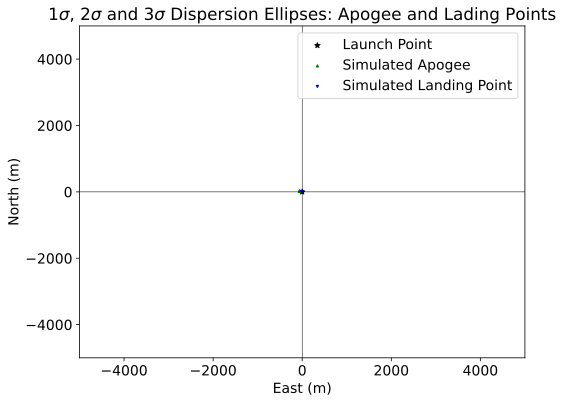




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 11, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.09375 s. Total wall time: 9.902506828308105 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.548 
Out Of Rail Stability Margin - Standard Deviation: 0.032 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 93.43%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5316727274097333, 1.5650152833356188



Apogee Altitude -         Mean Value: 3050.531 
Apogee Altitude - Standard Deviation: 0.311 m


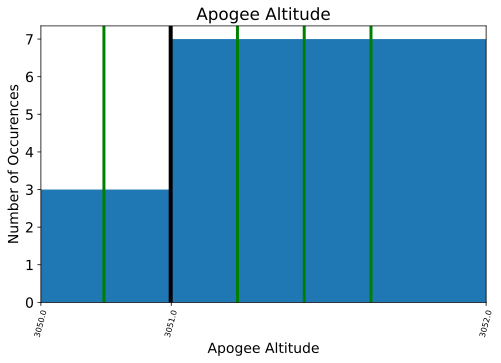

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3050.368978966458, 3050.6924947346038

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is 25.734088395847653
Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


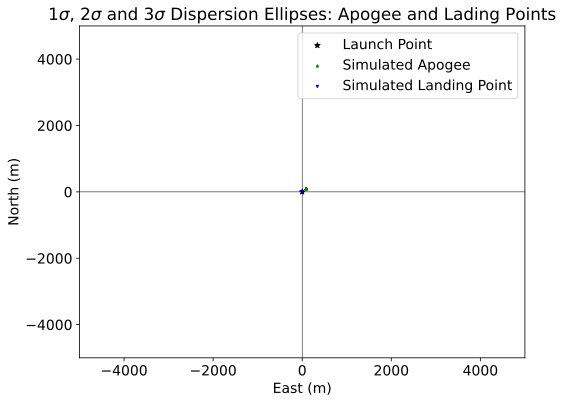




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 12, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.125 s. Total wall time: 9.78334665298462 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.561 
Out Of Rail Stability Margin - Standard Deviation: 0.054 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 87.29%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5333169433921232, 1.589223912984652



Apogee Altitude -         Mean Value: 3047.125 
Apogee Altitude - Standard Deviation: 0.220 m


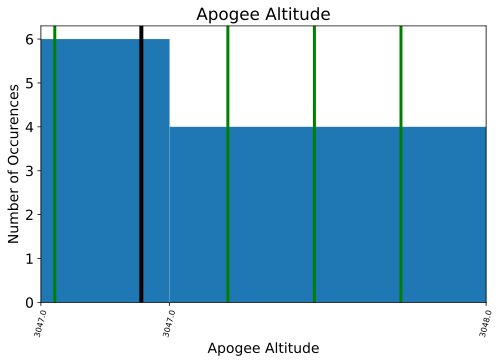

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3047.010208437742, 3047.2388226344583

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -12.598025988504954
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


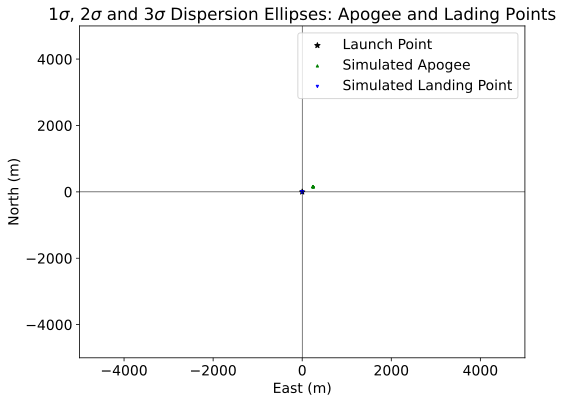




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 13, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.125 s. Total wall time: 9.613001823425293 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.541 
Out Of Rail Stability Margin - Standard Deviation: 0.038 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 85.85%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.52111106989695, 1.560786243960561



Apogee Altitude -         Mean Value: 3040.100 
Apogee Altitude - Standard Deviation: 0.217 m


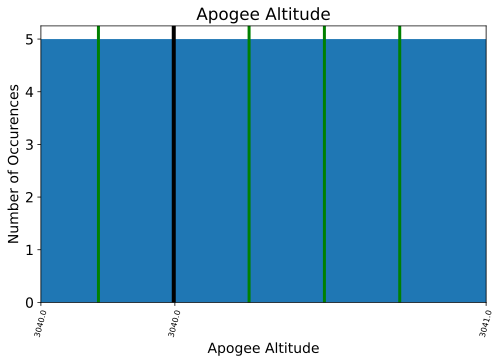

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3039.9870615200302, 3040.212845610386

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -115.10483321367894
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


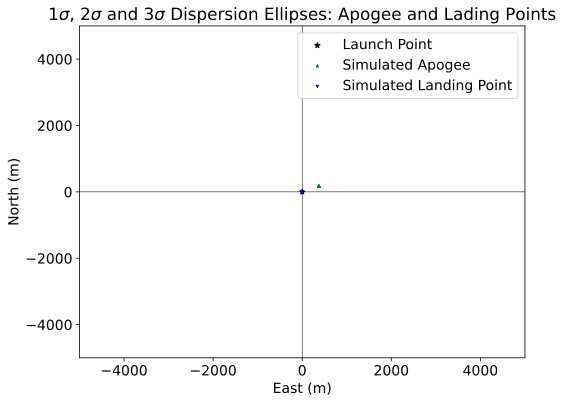




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 14, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.140625 s. Total wall time: 9.562429904937744 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.570 
Out Of Rail Stability Margin - Standard Deviation: 0.026 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 99.71%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5570929423739017, 1.5836388964427222



Apogee Altitude -         Mean Value: 3034.672 
Apogee Altitude - Standard Deviation: 0.266 m


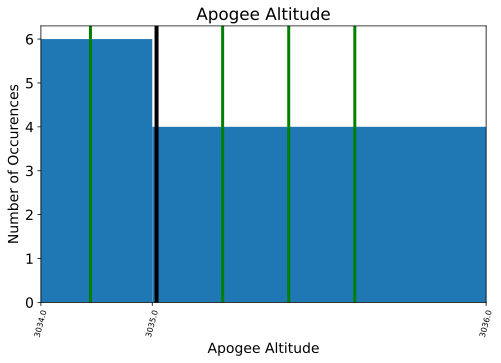

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3034.533563705631, 3034.8105674649037

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -158.28305954712346
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


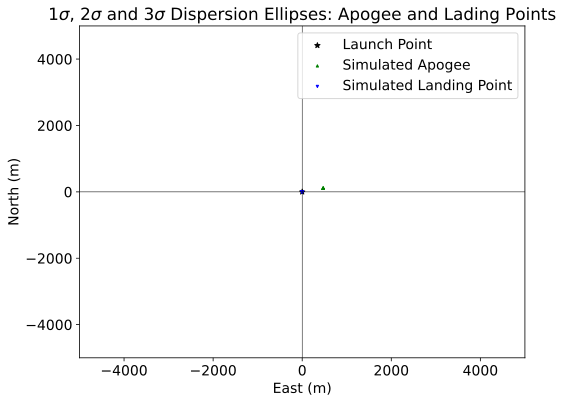




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 15, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.140625 s. Total wall time: 10.141413450241089 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.550 
Out Of Rail Stability Margin - Standard Deviation: 0.030 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 94.84%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5337864837016193, 1.5654630630133166



Apogee Altitude -         Mean Value: 3029.166 
Apogee Altitude - Standard Deviation: 0.182 m


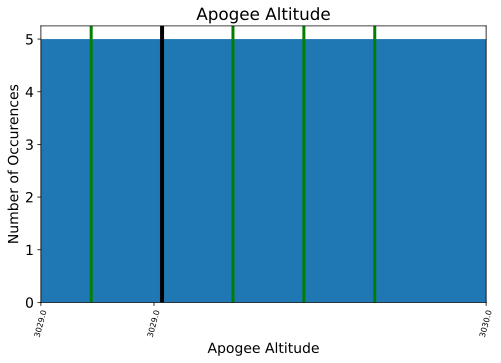

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3029.0712063923093, 3029.260995571629

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -326.4570427091364
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


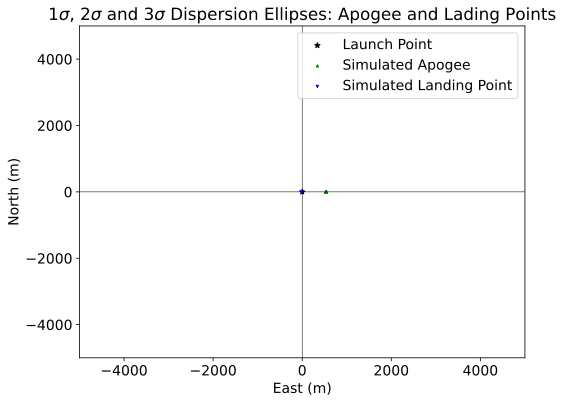




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 16, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.1875 s. Total wall time: 10.451892137527466 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.553 
Out Of Rail Stability Margin - Standard Deviation: 0.045 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 88.01%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5297595369291686, 1.5770016337547719



Apogee Altitude -         Mean Value: 3021.497 
Apogee Altitude - Standard Deviation: 0.303 m


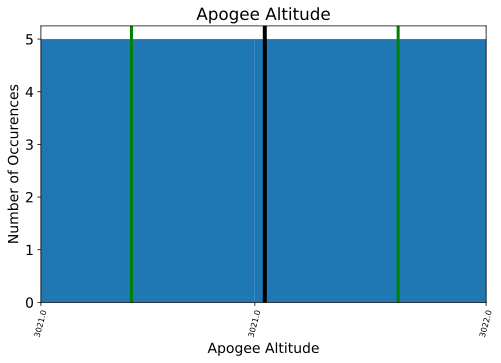

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 100.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3021.3399826738673, 3021.654960351301

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -276.7991716814162
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


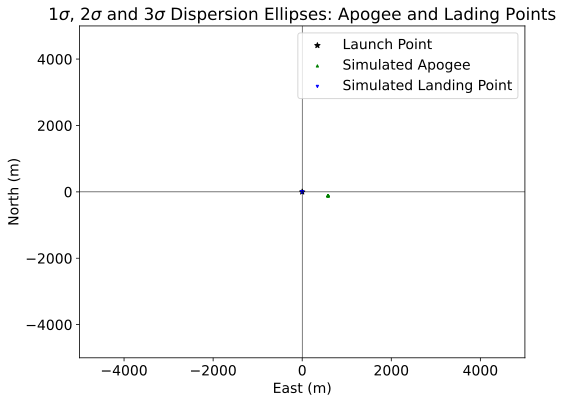




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 17, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.109375 s. Total wall time: 9.887983560562134 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.561 
Out Of Rail Stability Margin - Standard Deviation: 0.044 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 91.91%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5384024061628563, 1.583846100493027



Apogee Altitude -         Mean Value: 3010.654 
Apogee Altitude - Standard Deviation: 0.358 m


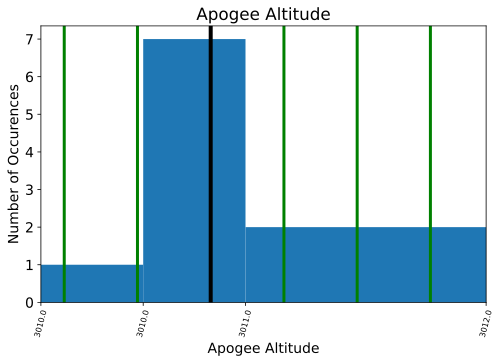

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3010.4673601148334, 3010.8397978385537

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -329.8774112366215
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


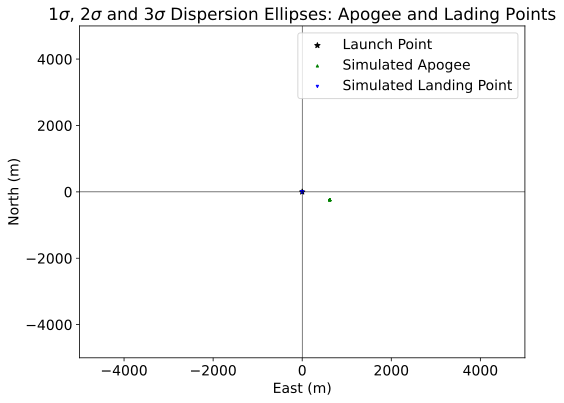




----------------------------------------------------------------------------------------------------



CURRENT HOUR IS 18, CURRENT DAY IS: 13


'Completed 1 iterations successfully. Total CPU time: 0.140625 s. Total wall time: 9.946673154830933 s'

Number of simulations:  10
Out Of Rail Stability Margin -         Mean Value: 1.555 
Out Of Rail Stability Margin - Standard Deviation: 0.048 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 87.14%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 1.5294942650344665, 1.5795613117606577



Apogee Altitude -         Mean Value: 2997.928 
Apogee Altitude - Standard Deviation: 0.329 m


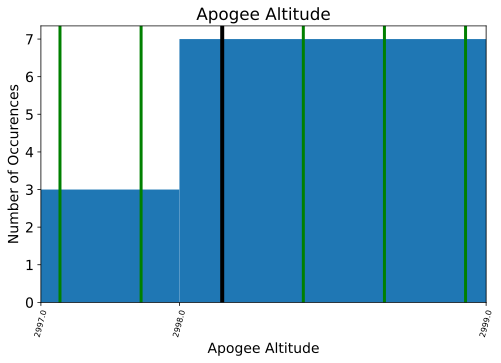

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.0%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2997.7570014496027, 2998.0996477908416

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -480.73227081946266
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 0.0, y = 0.0


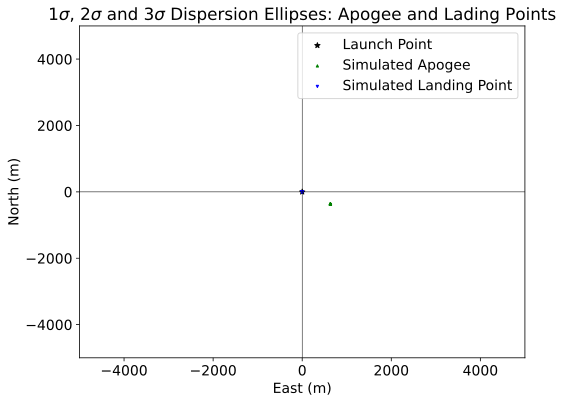




----------------------------------------------------------------------------------------------------





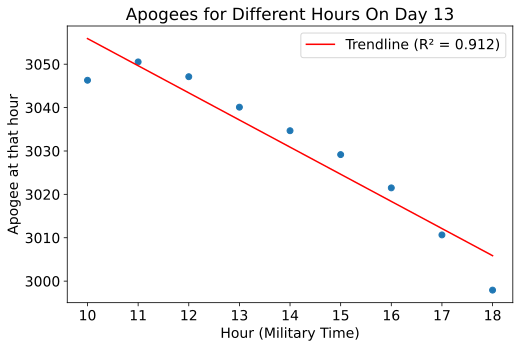

In [2]:
from datetime import datetime
from time import process_time, time
import pandas as pd
from rocketpy import Environment, SolidMotor, Rocket, Flight
import concurrent.futures
from ConcurrentFunctions import runFlightWithMonteCarlo
from rocketpy.motors import motor
from IPython.display import display
from scipy.stats import norm
from rocketpy.mathutils.function import Function
from rocketpy.environment import environment

#Calculate and plot landing elipses
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

import FlightParams

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

from wind import makeWind

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14


import logging
import numpy as np

# Iterate the loop to read the cell values

env = Environment(latitude = FlightParams.envParams["latitude"], longitude = FlightParams.envParams["longitude"], elevation = FlightParams.envParams["elevation"])

analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (FlightParams.spMass, 0), #.001
    # # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    # "rocket_inertia_11": (FlightParams.spCentralDiameter, 0.036),
    # # Rocket's inertia moment relative to its axis (kg*m^2)
    # "rocket_inertia_33": (FlightParams.spCentralAxis, 0.00001),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (FlightParams.dryMotorMass, 0), #.001
    # # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    # "motor_inertia_11": (FlightParams.motor_11_inertia, 0.016),
    # # Motors's dry inertia moment relative to its axis (kg*m^2)
    # "motor_inertia_33": (FlightParams.motor_33_inertia, 0.00001),\
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)
    # THIS is likely wrong, go back to check it

    "motor_dry_mass_position": (np.abs(FlightParams.the_motor_center_of_dry_mass_position - FlightParams.rocket_center_of_dry_mass_position), 0), #.001
    # Motor total impulse (N*s)
    "impulse": (FlightParams.impulse, 0), #25.3

    # "motor_position": (FlightParams.the_motor_position, .01),

    # Motor burn out time (s)
    # "burn_time": (FlightParams.burn_time, .3),
    # Motor's nozzle radius (m)
    "nozzle_radius": (FlightParams.the_nozzle_radius, 0), #.5 / 1000
    # Motor's nozzle throat radius (m)
    "throat_radius": (FlightParams.the_throat_radius, 0), #.5 / 1000
    # Motor's grain separation (axial distance between two grains) (m)
    # "grain_separation": (FlightParams.grainSeparation, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (FlightParams.motor_density, 0), #20
    # Motor's grain outer radius (m)
    # "grain_outer_radius": (FlightParams.grainOuterRadius, 0.3 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (FlightParams.grainInnerRadius, 0), #.3 / 1000
    # Motor's grain height (m)
    "grain_initial_height": (FlightParams.grainHeight, 0), #1 / 1000
    # Rocket's radius (kg*m^2)
    # "radius": (FlightParams.spRadius, 0.001),
    # Nozle position relative to motor
    # "nozzle_position": (FlightParams.the_nozzle_position, 0.001),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (FlightParams.rocket_center_of_dry_mass_position-(FlightParams.the_motor_center_of_dry_mass_position + FlightParams.the_motor_position), 0), #.0001
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    # "nose_distance_to_CM": (FlightParams.rocket_center_of_dry_mass_position-FlightParams.nose_cone_length, 0.001),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (FlightParams.inclination, 0), #1
    # Launch rail heading relative to north (degrees)
    "heading": (FlightParams.heading, 0), #2
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (FlightParams.drogueCdS, 0), #.02
    # Drag coefficient times reference area for the light chute
    "cd_s_light": (FlightParams.lightCdS, 0), #.02
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (FlightParams.lag_rec, 0), #.2
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (FlightParams.lag_se, 0), #.1
    # temperature in kelvin
    "temperature": (FlightParams.kelvin_temp, 0), #5
    # atmospheric pressure in pascals
    "atmosphere_pressure": (env.pressure_ISA(FlightParams.envParams["elevation"]), 0), #300

    #without motor
    "rocket_CM": (FlightParams.rocket_center_of_dry_mass_position, 0.01),

    # adding these, but they don't vary
    "time_to_deploy_airbrake_after_burnout": (-1, 0),
    "fin_position": (2.62, 0)
}

# M1850W.all_info()

#sets up the ability to log inputs.
def setup_logging():
    class MyHandler(logging.FileHandler):
        def emit(self, record):
            super().emit(record)  # Call the superclass's emit method
            self.flush()  # Flush after each log message

    # Use your custom handler
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = MyHandler('app.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

resultsFile = open(FlightParams.generatedFilesLocation + "results.txt", "w")

def createDistributionPlot(dispersonResultArray, name, lowerProbBound, upperProbBound, maxDecimals, percentConfidence, hypothesis, unit, makeGraph, filename):
    mean = np.mean(dispersonResultArray)
    deviation = np.std(dispersonResultArray)
    unitString = ""
    if(unit == "meters"):
        unitString = "m"
    print(
        f'{name} -         Mean Value: {mean:0.3f} ' + unitString
    )
    resultsFile.write(f'{name} -         Mean Value: {mean:0.3f} ' + unitString + "\n")
    print(
        f'{name} - Standard Deviation: {deviation:0.3f} m' + unitString
    )
    resultsFile.write(f'{name} - Standard Deviation: {deviation:0.3f} m' + unitString + "\n")
    if(makeGraph):

        minimum = np.min(dispersonResultArray)
        maximum = np.max(dispersonResultArray)
        theBins = list()

        #using scott's rule to find the number of bins
        binWidth = 3.5 * deviation / np.power(len(dispersonResultArray), 1/3)
        numBins = int(np.round((maximum-minimum)/binWidth))

        changeInZ = (maximum - minimum) / numBins
        #test add
        zIterator = minimum
        for iterator in range(numBins):
            theBins.append(zIterator)
            zIterator += changeInZ
        finalValue = np.ceil(zIterator * np.power(10, maxDecimals)) / np.power(10, maxDecimals)
        theBins.append(finalValue)
        plt.figure()
        plt.xlim(minimum, maximum)
        minTextSize = 8
        maxTickCount = 50
        xTickBins = theBins
        if(numBins > maxTickCount):
            xTickBins = list()
            changeInZ = (maximum - minimum) / 50.0
            zIterator = minimum
            for iterator in range(50):
                xTickBins.append(zIterator)
                zIterator += changeInZ
        binListToString = list()
        for currentBin in xTickBins:
            binListToString.append(str(round(currentBin, maxDecimals)))
        plt.xticks(ticks = xTickBins, labels = binListToString, rotation = 75, fontsize = minTextSize)
        plt.hist(dispersonResultArray, bins=theBins)
        plt.title(name)
        plt.xlabel(name)
        plt.ylabel("Number of Occurences")

        plt.axvline(mean, color='k', linestyle='solid', linewidth=4)
        plt.axvline(mean - deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.savefig(FlightParams.generatedFilesLocation + str(filename) + "Graph.png", bbox_inches="tight", pad_inches=0)
        plt.show()
    lowerZ = (lowerProbBound - mean)/deviation
    upperZ = (upperProbBound - mean)/deviation
    probabilityInRange = norm.cdf(upperZ) - norm.cdf(lowerZ)
    print("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%")
    resultsFile.write("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%\n")
    if(percentConfidence != 100):
        aVal = (100 - percentConfidence)/100
        newZ = np.abs(norm.ppf(aVal/2))
        lowerBoundOfInterval = mean - newZ * deviation/np.sqrt(len(dispersonResultArray))
        upperBoundOfInterval = mean + newZ * deviation/np.sqrt(len(dispersonResultArray))
        print("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval))
        resultsFile.write("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval) + "\n")
        if(hypothesis != None):
            criticalValue = norm.ppf(aVal / 2)
            testStatistic = (mean - hypothesis) * np.sqrt(len(dispersonResultArray))/deviation
            print("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic))
            resultsFile.write("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic) + "\n")
            if(testStatistic < criticalValue):
                print("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
                resultsFile.write("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n\n")
            else:
                print("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
                resultsFile.write("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n\n")

# envParams["file"] = row[0].value

print("TOTAL SIMS IS: " + str(FlightParams.numberSims))
resultsFile.write("TOTAL SIMS IS: " + str(FlightParams.numberSims) + "\n\n\n")

wind = makeWind(13, 11)

for day in [11, 12, 13]:
    varyingParamVals = []
    apogeeAtIteration = []
    currentVal = -1
    endVal = -1
    incrementAmount = -1
    if(FlightParams.varyingVariable == "airbrake"):   
        currentVal = 1
        endVal = 21
        incrementAmount = 1
    elif (FlightParams.varyingVariable == "finposition"):
        currentVal = 2.55
        endVal = 2.62
        incrementAmount = 0.005
    elif (FlightParams.varyingVariable == "weatherHour"):
        currentVal = 10
        endVal = 18
        incrementAmount = 1
    
    #range only accepts integer values, so for now we make them integers and divide them later
    while(True):
        if(FlightParams.varyingVariable == "airbrake"):
            print("THIS IS WHERE WE DEPLOY AIRBRAKE " + str(currentVal) + " SECONDS AFTER BURNOUT")
            resultsFile.write("THIS IS WHERE WE DEPLOY AIRBRAKE " + str(currentVal) + " SECONDS AFTER BURNOUT\n")
            analysis_parameters["time_to_deploy_airbrake_after_burnout"] = (currentVal, 0)
            varyingParamVals.append(currentVal)
        elif(FlightParams.varyingVariable == "finposition"):
            print("CURRENT FIN POSITION IS " + str(currentVal))
            resultsFile.write("CURRENT FIN POSITION IS " + str(currentVal) + "\n")
            analysis_parameters["fin_position"] = (currentVal, 0)
            varyingParamVals.append(currentVal)
        elif(FlightParams.varyingVariable == "weatherHour"):
            wind = makeWind(currentVal, day)
            print("CURRENT HOUR IS " + str(currentVal) + ", CURRENT DAY IS: " + str(day))
            resultsFile.write("CURRENT HOUR IS " + str(currentVal) + ", CURRENT DAY IS: " + str(day) + "\n")
            varyingParamVals.append(currentVal)

        setup_logging()
        # env.all_info()
        # Create data files for inputs, outputs and error logging
        filename = "MonteCarlo" + str(currentVal)
        MonteCarloErrorFile = open("CreatedFiles/" + str(filename) + ".Errors.txt", "w")
        MonteCarloInputFile = open("CreatedFiles/" + str(filename) + ".Input.txt", "w")
        MonteCarloOutputFile = open("CreatedFiles/" + str(filename) + ".Output.txt", "w")

        initial_wall_time = time()
        initial_cpu_time = process_time()
        # Iterate over flight settings
        out = display("Starting", display_id=True)
        number_of_simulations = FlightParams.numberSims
        totalProcesses = FlightParams.processes
        simsPerProcess = number_of_simulations / totalProcesses

        # start multiprocessing
        if __name__ == "__main__":
            with concurrent.futures.ProcessPoolExecutor(max_workers=totalProcesses) as executor:
                results = [executor.submit(runFlightWithMonteCarlo, simsPerProcess, FlightParams.envParams, analysis_parameters, initial_cpu_time, False, wind) for _ in range(totalProcesses)] 
                for result in concurrent.futures.as_completed(results):
                    MonteCarloInputFile.write(result.result()[0] + "\n")
                    MonteCarloOutputFile.write(result.result()[1] + "\n")
                    MonteCarloErrorFile.write(result.result()[2] + "\n")

        ## Print and save total time
        final_string = f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
        resultsFile.write(f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s\n")
        out.update(final_string)
        MonteCarloInputFile.write(final_string + "\n")
        MonteCarloOutputFile.write(final_string + "\n")
        MonteCarloErrorFile.write(final_string + "\n")

        ## Close files
        MonteCarloInputFile.close()
        MonteCarloOutputFile.close()
        MonteCarloErrorFile.close()

        # Initialize variable to store all results
        dispersion_general_results = []

        dispersion_results = {
            "out_of_rail_time": [],
            "out_of_rail_velocity": [],
            "apogee_time": [],
            "apogee_altitude": [],
            "apogee_x": [],
            "apogee_y": [],
            "impact_x": [],
            "impact_y": [],
            "initial_static_margin": [],
            "out_of_rail_static_margin": [],
            "out_of_rail_stability_margin": [],
            "max_velocity": [],
            "execution_time": [],
        }

        # Get all dispersion results
        # Get file
        dispersion_output_file = open("CreatedFiles/" + str(filename) + ".Output.txt", "r+")

        # Read each line of the file and convert to dict
        for line in dispersion_output_file:
            # Skip comments lines
            if line[0] != "{":
                continue
            # Eval results and store them
            flight_result = eval(line)
            dispersion_general_results.append(flight_result)
            for parameter_key, parameter_value in flight_result.items():
                dispersion_results[parameter_key].append(parameter_value)

        # Close data file
        dispersion_output_file.close()

        # Print number of flights simulated
        N = len(dispersion_general_results)
        print("Number of simulations: ", N)
        resultsFile.write("Number of simulations: " + str(N) + "\n")

        # Retrieve dispersion data por apogee and impact XY position
        apogee_x = np.array(dispersion_results["apogee_x"])
        apogee_y = np.array(dispersion_results["apogee_y"])

        createDistributionPlot(dispersion_results["out_of_rail_stability_margin"], "Out Of Rail Stability Margin", lowerProbBound = 1.5, upperProbBound = 4, maxDecimals = 4, percentConfidence = 90, hypothesis = None, unit = "none", makeGraph = False, filename = "Rail" + str(currentVal))
        print("\n\n")
        resultsFile.write("\n\n")
        createDistributionPlot(dispersion_results["apogee_altitude"], "Apogee Altitude", lowerProbBound = 9900 * 0.3048, upperProbBound = 10100 * 0.3048, maxDecimals = 0, percentConfidence = 90, hypothesis = 3048, unit = "meter", makeGraph = True, filename = "Apogee" + str(currentVal))
        print("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
        resultsFile.write("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
        apogeeAtIteration.append(np.mean(dispersion_results["apogee_altitude"]))

        #img = imread("background.jpeg")

        # Retrieve dispersion data por apogee and impact XY position
        impact_x = np.array(dispersion_results["impact_x"])
        impact_y = np.array(dispersion_results["impact_y"])

        print(f"Simulated Landing Position x = {np.mean(dispersion_results['impact_x'])}, y = {np.mean(dispersion_results['impact_y'])}")
        resultsFile.write(f"Simulated Landing Position x = {np.mean(dispersion_results['impact_x'])}, y = {np.mean(dispersion_results['impact_y'])}\n")
        # Define function to calculate eigen values
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:, order]


        # Create plot figure
        plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
        ax = plt.subplot(111)

        # Calculate error ellipses for impact
        impactCov = np.cov(impact_x, impact_y)
        impactVals, impactVecs = eigsorted(impactCov)
        impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
        impactW, impactH = 2 * np.sqrt(impactVals)

        # Draw error ellipses for impact
        impact_ellipses = []
        for j in [1, 2, 3]:
            impactEll = Ellipse(
                xy=(np.mean(impact_x), np.mean(impact_y)),
                width=impactW * j,
                height=impactH * j,
                angle=impactTheta,
                color="black",
            )
            impactEll.set_facecolor((0, 0, 1, 0.2))
            impact_ellipses.append(impactEll)
            ax.add_artist(impactEll)

        # Calculate error ellipses for apogee
        apogeeCov = np.cov(apogee_x, apogee_y)
        apogeeVals, apogeeVecs = eigsorted(apogeeCov)
        apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
        apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

        # Draw error ellipses for apogee
        for j in [1, 2, 3]:
            apogeeEll = Ellipse(
                xy=(np.mean(apogee_x), np.mean(apogee_y)),
                width=apogeeW * j,
                height=apogeeH * j,
                angle=apogeeTheta,
                color="black",
            )
            apogeeEll.set_facecolor((0, 1, 0, 0.2))
            ax.add_artist(apogeeEll)

        # Draw launch point
        plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
        # Draw apogee points
        plt.scatter(
            apogee_x, apogee_y, s=5, marker="^", color="green", label="Simulated Apogee"
        )
        # Draw impact points
        plt.scatter(
            impact_x, impact_y, s=5, marker="v", color="blue", label="Simulated Landing Point"
        )

        plt.legend()

        # Add title and labels to plot
        ax.set_title(
            "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points"
        )
        ax.set_ylabel("North (m)")
        ax.set_xlabel("East (m)")

        # Add background image to plot
        # You can translate the basemap by changing dx and dy (in meters)
        dx = 0
        dy = 0
        #plt.imshow(img, zorder=0, extent=[-1000 - dx, 1000 - dx, -1000 - dy, 1000 - dy])

        plt.axhline(0, color="black", linewidth=0.5)
        plt.axvline(0, color="black", linewidth=0.5)
        plt.xlim(-5000, 5000)
        plt.ylim(-5000, 5000)

        # Save plot and show result
        plt.savefig("CreatedFiles/" + str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
        plt.savefig("CreatedFiles/" + str(filename) + ".svg", bbox_inches="tight", pad_inches=0)
        plt.show()
        print("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
        resultsFile.write("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")

        currentVal += incrementAmount
        currentVal = round(currentVal, 5 )
        if(currentVal > endVal):
            break

    plt.scatter(varyingParamVals, apogeeAtIteration)
    if(FlightParams.varyingVariable == "airbrake"):
        plt.title("Apogees at Different Deployment Times")
        plt.xlabel("Airbrake Deployment Time (Seconds after Burnout)")
        plt.ylabel("Apogee for that Time")
    elif(FlightParams.varyingVariable == "finposition"):
        plt.title("Apogees at Different Fin Positions")
        plt.xlabel("Fin Position")
        plt.ylabel("Apogee for that Position")
    elif(FlightParams.varyingVariable == "weatherHour"):
        plt.title(f"Apogees for Different Hours On Day {day}")
        plt.xlabel("Hour (Military Time)")
        plt.ylabel("Apogee at that hour")
        
    #creating the trendline with the given x and y values
    trendline = np.polyfit(varyingParamVals, apogeeAtIteration, 1)
    trendline = np.poly1d(trendline)
    # obtaining the y values from the trendline
    y_vals = trendline(varyingParamVals)

    # R^2 calculation
    residuals = apogeeAtIteration - y_vals
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((apogeeAtIteration - np.mean(apogeeAtIteration))**2)
    r_squared = 1 - (ss_res / ss_tot)

    #plotting the trendline
    plt.plot(varyingParamVals, y_vals, "r", label="Trendline (R² = " + str(round(r_squared, 3)) + ")")
    plt.legend()

    plt.savefig(FlightParams.generatedFilesLocation + f"FinalSimTable{day}.png", bbox_inches="tight", pad_inches=0)
    plt.show()
resultsFile.close()